In [2]:
# Almgren-Chriss Framework through Dynamic Programming
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import numba as nb

In [3]:
t_s = np.random.standard_t(4, 5)/100
t_innovation = 1+t_s
_s0_t = 50*np.cumprod(t_innovation)
_s0_t = np.append(50,_s0_t)
_cs_t = 0.3/np.sqrt(250)
_sigma_t = [_cs_t * _s0_t]
_sigma_t = np.squeeze(_sigma_t)

print(_sigma_t)
np.mean(_sigma_t)

[0.9486833  0.95958151 0.96363338 0.96526879 0.9455393  0.94236041]


0.9541777801132847

In [4]:
# Utilities
@nb.njit()
def h(x, alpha, eta):
    return eta * x ** (alpha)

@nb.njit()
def g(x, beta, gamma):
    return gamma * x ** (beta)

@nb.njit()
def H(x,n,psi,alpha,beta,gamma,eta,sigma=0.5771878697192828,tau=1):
    """
    Hamiltonian equation. To be minimized through dynamic programming.
    """
    res = psi*n*g(n/tau,beta,gamma) + psi*(x-n)*tau*h(n/tau,alpha,eta) + 0.5*(psi**2)*(sigma**2)*tau*((x-n)**2)
    return res

Dynamic Programming: A simplified version
Bellman equation with change of variable

In [5]:
def dynamic_programming_old(nb_T, X_total, psi, alpha, beta, gamma, eta, plot='True'):
    
    """
    MODEL
    - Bellman equation and value iteration for solving the Markov
      Decision Process of the Almgren-Chriss model.
    
    INPUTS
    - nb_T,       number of time steps
    - X_total,    number of shares to be liquidated
    - psi,        risk aversion
    """
    
    ### Initialization
    u = np.zeros(shape=(nb_T, X_total+1), dtype="float64")      # value function
    b = np.zeros(shape=(nb_T, X_total+1), dtype="int")          # best move
    inventoryforX = np.zeros(shape=(nb_T,1), dtype="int")       # evolution of inventory
    inventoryforX[0] = X_total
    N = []                                                      # optimal selling trajectory
    tau = 0.5
    
    ### Market microstructure: volatility, correlation
    ### [insert dynamic volatility data]
    
    ### Terminal condition
    for x in range(X_total+1):
        u[nb_T - 1, x] = np.exp(x * h(x/tau, alpha, eta))
        b[nb_T - 1, x] = x
    
    ### Backwards induction
    for t in range(nb_T-2, -1, -1):
        for x in range(X_total+1):
            
            best_value = u[t+1,0] * np.exp(H(x, x, psi, alpha, beta, gamma, eta))
            best_n = x
            
            for n in range(x):
                # We compute the utility function if we sell n shares
                current_value = u[t+1,x-n] * np.exp(H(x, n, psi, alpha, beta, gamma, eta))
                
                if current_value < best_value:
                    best_value = current_value
                    best_n = n   # nb of shares to liquidate
               
            u[t,x] = best_value
            b[t,x] = best_n
    
    ### Optimal trajectory
    for t in range(1, nb_T):
        inventoryforX[t] = inventoryforX[t-1] - b[t,inventoryforX[t-1]]
        N.append(b[t,inventoryforX[t-1]])
    
    N = np.asarray(N)
    
    # ### Plot results
    # if plot:
    #     plt.figure(figsize=(7,5))
    #     plt.plot(inventoryforX, color='blue', lw=1.5)
    #     plt.xlabel('Trading periods')
    #     plt.ylabel('Number of shares')
    #     plt.grid(True)
    #     plt.show()
    
    return u, b, inventoryforX, N

In [6]:
@nb.njit(parallel=True)
def x_loop(X_total,ut,psi,alpha,beta,gamma,eta):

    u_t = np.zeros((X_total+1))
    b_t = np.zeros((X_total+1))

    for x in nb.prange(X_total+1):
        
        nn = np.arange(x+1)
        value = ut[x-nn] * np.exp(H(x, nn, psi, alpha, beta, gamma, eta))

        u_t[x] = np.min(value)
        b_t[x] = nn[np.argmin(value)]


    return u_t,b_t

def dynamic_programming(nb_T, X_total, psi, alpha, beta, gamma, eta, plot='True'):
    
    """
    MODEL
    - Bellman equation and value iteration for solving the Markov
      Decision Process of the Almgren-Chriss model.
    
    INPUTS
    - nb_T,       number of time steps
    - X_total,    number of shares to be liquidated
    - psi,        risk aversion
    """
    
    ### Initialization
    u = np.zeros(shape=(nb_T, X_total+1), dtype="float64")      # value function
    b = np.zeros(shape=(nb_T, X_total+1), dtype="int")          # best move
    inventoryforX = np.zeros(shape=(nb_T,1), dtype="int")       # evolution of inventory
    inventoryforX[0] = X_total
    N = np.zeros((nb_T-1,1))                                    # optimal selling trajectory
    tau = 1
    
    ### Market microstructure: volatility, correlation
    ### [insert dynamic volatility data]
    
    ### Terminal condition
    xx = np.arange(X_total+1)
    
    u[-1, :] = np.exp(xx * h(xx/tau, alpha, eta))
    b[-1, :] = xx


    ### Backwards induction
    for t in range(nb_T-2, -1, -1):

        u_t,b_t = x_loop(X_total,u[t+1],psi,alpha,beta,gamma,eta)

        u[t,:] = u_t
        b[t,:] = b_t

    ### Optimal trajectory
    for t in range(1, nb_T):
        inventoryforX[t] = inventoryforX[t-1] - b[t,inventoryforX[t-1]]
        N[t-1] = b[t,inventoryforX[t-1]]
    
    return u, b, inventoryforX, N

In [7]:
import sys
sys.path.append(r"C:\Users\jeope\AppData\Roaming\Microsoft\Windows\Start Menu\Programs\MiKTeX\MiKTeX Console.lnk")

from seaborn import color_palette, set_palette
from matplotlib import rc, cm

plt.style.use('seaborn-white')
set_palette("deep")

rc('font', **{'family': 'serif', 'serif': ['Palatino']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{underscore}')

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

C:\Users\jeope\AppData\Local\Temp\ipykernel_24080\3087820583.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


Different levels of risk, i.e., $\psi$

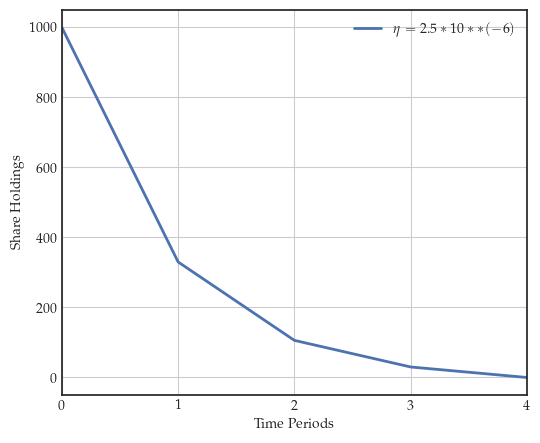

In [18]:
#u1, b1, p1, N1 = dynamic_programming(nb_T=6, X_total=100, psi=2*10**(-6), alpha=0.02, beta=1, gamma=2.5*10**(-7), eta=2.5*10**(-7), plot='False')
#u2, b2, p2, N2 = dynamic_programming(nb_T=6, X_total=200, psi=2*10**(-6), alpha=0.02, beta=1, gamma=2.5*10**(-7), eta=2.5*10**(-6), plot='False')
#u3, b3, p3, N3 = dynamic_programming(nb_T=6, X_total=500, psi=2*10**(-6), alpha=0.02, beta=1, gamma=2.5*10**(-7), eta=2.5*10**(-5), plot='False')
#u4, b4, p4, N4 = dynamic_programming(nb_T=6, X_total=1000, psi=2*10**(-6), alpha=0.02, beta=1, gamma=2.5*10**(-7), eta=2.5*10**(-4), plot='False')
#u5, b5, p5, N5 = dynamic_programming(nb_T=6, X_total=2000, psi=2*10**(-6), alpha=0.02, beta=1, gamma=2.5*10**(-7), eta=2.5*10**(-3), plot='False')
#u6, b6, p6, N6 = dynamic_programming(nb_T=6, X_total=5000, psi=2*10**(-6), alpha=0.02, beta=1, gamma=2.5*10**(-7), eta=2.5*10**(-2), plot='False')
u7, b7, p7, N7 = dynamic_programming(nb_T=6, X_total=1000, psi=2*10**(-6), alpha=0.02, beta=1, gamma=2.5*10**(-7), eta=2.5*10**(-6), plot='False')
#print(p1)
#print(p2)
#print(p3)

plt.figure(figsize=(6,5))
#plt.plot(p1[0:5], lw=2, label=r'$\eta=2.5*10**(-7)$')
#plt.plot(p2[0:5], lw=2, label=r'$\eta=2.5*10**(-6)$')
#plt.plot(p3[0:5], lw=2, label=r'$\eta=2.5*10**(-5)$')
#plt.plot(p4[0:5], lw=2, label=r'$\eta=2.5*10**(-4)$')
#plt.plot(p5[0:5], lw=2, label=r'$\eta=2.5*10**(-3)$')
#plt.plot(p6[0:5], lw=2, label=r'$\eta=2.5*10**(-2)$')
plt.plot(p7[0:5], lw=2, label=r'$\eta=2.5*10**(-6)$')
#plt.scatter(np.arange(0, 5), p1[0:5],  lw=2)
#plt.scatter(np.arange(0, 5), p2[0:5],  lw=2)
#plt.scatter(np.arange(0, 5), p3[0:5],  lw=2)
#plt.scatter(np.arange(0, 5), p4[0:5],  lw=2)
#plt.scatter(np.arange(0, 5), p5[0:5],  lw=2)
#plt.scatter(np.arange(0, 5), p6[0:5],  lw=2)
#plt.scatter(np.arange(0, 5), p7[0:5],  lw=2)

plt.xlabel('Time Periods')
plt.ylabel('Share Holdings')
plt.legend(loc='best')
#plt.title('$\gamma=0.05$, $\eta=0.05$')
plt.xlim([0,4])
plt.xticks([0, 1, 2, 3, 4])
plt.grid(True)
plt.savefig('DP1.png')
plt.show()

In [16]:
print(p7)

[[1000]
 [ 330]
 [ 106]
 [  30]
 [   0]
 [   0]]


In [277]:
#psi_values = np.linspace(0.0002, 0.00000000000002, 1000)
psi_values = [2*10**(-4),2*10**(-5),2*10**(-6),2*10**(-7),2*10**(-8),2*10**(-10),2*10**(-15)]
dp_p1_list = []

for psi in psi_values:
    u1, b1, p1, N1 = dynamic_programming(nb_T=6, X_total=10000, psi=psi, alpha=0.02, beta=1, gamma=2.5*10**(-7), eta=2.5*10**(-6), plot=False)
    dp_p1 = np.diff(p1.reshape(1, 6)) * -1
    dp_p1_list.append(dp_p1)
    
    # Perform further operations with dp_p1 if desired
    # ...

# Access each dp_p1 array individually
for i, dp_p1 in enumerate(dp_p1_list):
    print(f"dp_p1_{i+1}: {dp_p1}")


dp_p1_1: [[9737  256    7    0    0]]
dp_p1_2: [[8155 1506  279   60    0]]
dp_p1_3: [[4581 2624 1613 1182    0]]
dp_p1_4: [[2807 2543 2369 2281    0]]
dp_p1_5: [[2540 2507 2484 2469    0]]
dp_p1_6: [[2507 2504 2497 2492    0]]
dp_p1_7: [[2234 2612 2531 2623    0]]


In [278]:
import pickle

# Save dp_p1_list
with open('dp_p2_list.pkl', 'wb') as f:
    pickle.dump(dp_p1_list, f)

In [192]:
print(dp_p1_list)

Parameters:
  lambda = 1e-08
  sigma = 0.5771878697192828
  epsilon = 1.3414613590037305
  eta = 3.6625459173846226e-05
  gamma = 3.6625459173846225e-06
  tau = 1

[array([[9737,  256,    7,    0,    0]]), array([[9734,  259,    7,    0,    0]]), array([[9732,  261,    7,    0,    0]]), array([[9729,  264,    7,    0,    0]]), array([[9726,  267,    7,    0,    0]]), array([[9724,  269,    7,    0,    0]]), array([[9721,  271,    8,    0,    0]]), array([[9718,  274,    8,    0,    0]]), array([[9715,  277,    8,    0,    0]]), array([[9712,  280,    8,    0,    0]]), array([[9709,  283,    8,    0,    0]]), array([[9706,  286,    8,    0,    0]]), array([[9703,  288,    9,    0,    0]]), array([[9699,  292,    9,    0,    0]]), array([[9696,  295,    9,    0,    0]]), array([[9693,  298,    9,    0,    0]]), array([[9689,  302,    9,    0,    0]]), array([[9686,  304,   10,    0,    0]]), array([[9682,  308,   10,    0,    0]]), array([[9678,  312,   10,    0,    0]]), array([[9674,  316,   10,    0,    0]]), array([[9670,  319,   11,    0,    0]]), array([[9667,  322,   11,    0,    0]]), array([[9662,  327,   11,    0,    0]]), array([[9658,  

[[10000]
 [ 7292]
 [ 4764]
 [ 2353]
 [    0]
 [    0]]
[[10000]
 [ 7524]
 [ 5022]
 [ 2522]
 [    0]
 [    0]]
[[10000]
 [ 7292]
 [ 4764]
 [ 2353]
 [    0]
 [    0]]


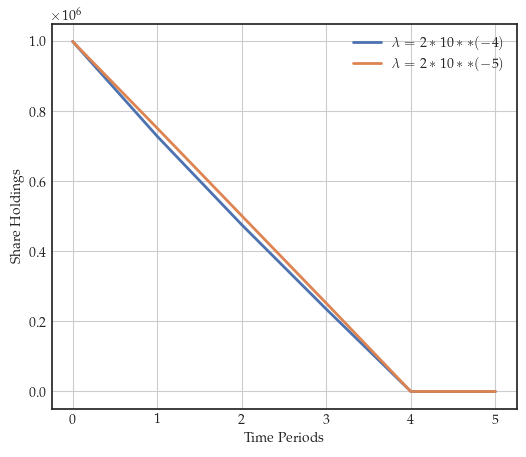

In [284]:
sigma_pg = 0.5771878697192828
epsilon_pg = 1.3414613590037305
gamma_pg = 3.6625459173846225e-06
u1, b1, p1, N1 = dynamic_programming(nb_T=6, X_total=10000, psi=2*10**(-6), alpha=0.02, beta=1, gamma=gamma_pg, eta=2.5*10**(-6), plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=6, X_total=10000, psi=0.00000000000002, alpha=0.02, beta=1, gamma=gamma_pg, eta=2.5*10**(-6), plot='False')
#u3, b3, p3, N3 = dynamic_programming(nb_T=6, X_total=10000, psi=0.000002, alpha=0.02, beta=1, gamma=gamma_pg, eta=2.5*10**(-6), plot='False')
#u4, b4, p4, N4 = dynamic_programming(nb_T=6, X_total=100, psi=0.0000002, alpha=0.02, beta=1, gamma=2.5*10**(-7), eta=2.5*10**(-6), plot='False')
#u5, b5, p5, N5 = dynamic_programming(nb_T=6, X_total=100, psi=0.00000002, alpha=0.02, beta=1, gamma=2.5*10**(-7), eta=2.5*10**(-6), plot='False')
#u6, b6, p6, N6 = dynamic_programming(nb_T=6, X_total=100, psi=0.0000000002, alpha=0.02, beta=1, gamma=2.5*10**(-7), eta=2.5*10**(-6), plot='False')
#u7, b7, p7, N7 = dynamic_programming(nb_T=6, X_total=100, psi=0.00000000000002, alpha=0.02, beta=1, gamma=2.5*10**(-7), eta=2.5*10**(-6), plot='False')
print(p1)
print(p2)
print(p3)

plt.figure(figsize=(6,5))
plt.plot(p1*100, lw=2, label='$\lambda=2*10**(-4)$')
plt.plot(p2*100, lw=2, label='$\lambda=2*10**(-5)$')
#plt.plot(p3, lw=2, label='$\lambda=2*10**(-6)$')
#plt.plot(p4, lw=2, label='$\lambda=2*10**(-7)$')
#plt.plot(p5, lw=2, label='$\lambda=2*10**(-8)$')
#plt.plot(p6, lw=2, label='$\lambda=2*10**(-10)$')
#plt.plot(p7, lw=2, label='$0$')
#plt.scatter(np.arange(0, 6), p1,  lw=2)
#plt.scatter(np.arange(0, 6), p2,  lw=2)
#plt.scatter(np.arange(0, 6), p3,  lw=2)
#plt.scatter(np.arange(0, 6), p4,  lw=2)
#plt.scatter(np.arange(0, 6), p5,  lw=2)
#plt.scatter(np.arange(0, 6), p6,  lw=2)
#plt.scatter(np.arange(0, 6), p7,  lw=2)

plt.xlabel('Time Periods')
plt.ylabel('Share Holdings')
plt.legend(loc='best')
#plt.title('$\gamma=0.05$, $\eta=0.05$')
plt.grid(True)
plt.savefig('DP1.png')
plt.show()